# Importing & Loading Dependencies

In [1]:
!pip install monai

import nibabel as nib
from monai.transforms import LoadImage, Compose, NormalizeIntensityd, RandFlipd, RandAdjustContrastd, Resized,  CropForegroundd, SpatialPadd, AsDiscrete
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Optional, Sequence, Tuple, Union
from torch.nn.functional import interpolate

from monai.networks.blocks.convolutions import Convolution
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.utils import get_act_layer, get_norm_layer
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.inferers import sliding_window_inference

from torch import nn, optim, amp
from itertools import chain
from monai.losses import DiceLoss

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA

from tqdm import tqdm
from pathlib import Path
import math
import os
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.7 MB/s eta 0:00:0000:0100:01


# Visualizing Data

In [2]:
# args = {
#     'workers': 2,
#     'epochs': 10,
#     'train_batch_size': 2,
#     'val_batch_size': 2,
#     'test_batch_size': 2,
#     'learning_rate': 1e-3,
#     'weight_decay': 1e-5,
#     'lambd': 0.0051,
#     'data_dir': '/kaggle/input/bratsafrica24/',
#     'in_checkpoint_dir': Path('/kaggle/input/adultgliomamodel-45epochs'),
#     'out_checkpoint_dir': Path('/kaggle/working/')
# }

# trainLoader, valLoader, testLoader = prepare_data_loaders(args)

# for step, y in enumerate( trainLoader ):
#   print(y['imgs'].shape)
#   print(y['patient_id'])

#   fig, axes = plt.subplots(1, 4, figsize=(16, 4))
#   for sequence in range(4):
#     sequence_data = y['imgs'][0][sequence, :, :, :].cpu().detach().numpy()
#     slice_index = sequence_data.shape[2] // 2
#     axes[sequence].imshow(np.rot90(sequence_data[:, :, slice_index]), cmap='gray', origin='lower')
#     axes[sequence].set_title(f'Sequence {sequence + 1}')

#   plt.show()

# DynUNet Model

In [3]:
class UnetBasicBlock(nn.Module):
    """
    A CNN module module that can be used for DynUNet, based on:
    `Automated Design of Deep Learning Methods for Biomedical Image Segmentation <https://arxiv.org/abs/1904.08128>`_.
    `nnU-Net: Self-adapting Framework for U-Net-Based Medical Image Segmentation <https://arxiv.org/abs/1809.10486>`_.

    Args:
        spatial_dims: number of spatial dimensions.
        in_channels: number of input channels.
        out_channels: number of output channels.
        kernel_size: convolution kernel size.
        stride: convolution stride.
        norm_name: feature normalization type and arguments.
        act_name: activation layer type and arguments.
        dropout: dropout probability.

    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[Sequence[int], int],
        stride: Union[Sequence[int], int],
        norm_name: Union[Tuple, str] = ("INSTANCE", {"affine": True}),
        act_name: Union[Tuple, str] = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
        dropout: Optional[Union[Tuple, str, float]] = None,
    ):
        super().__init__()
        self.conv1 = get_conv_layer(
            spatial_dims,
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            dropout=dropout,
            conv_only=True,
        )

        self.conv2 = get_conv_layer(
            spatial_dims,
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=1,
            dropout=dropout,
            conv_only=True
        )
        self.lrelu = get_act_layer(name=act_name)
        self.norm1 = get_norm_layer(name=norm_name, spatial_dims=spatial_dims, channels=out_channels)
        self.norm2 = get_norm_layer(name=norm_name, spatial_dims=spatial_dims, channels=out_channels)

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.norm1(out)
        out = self.lrelu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.lrelu(out)
        return out



class UnetUpBlock(nn.Module):
    """
    An upsampling module that can be used for DynUNet, based on:
    `Automated Design of Deep Learning Methods for Biomedical Image Segmentation <https://arxiv.org/abs/1904.08128>`_.
    `nnU-Net: Self-adapting Framework for U-Net-Based Medical Image Segmentation <https://arxiv.org/abs/1809.10486>`_.

    Args:
        spatial_dims: number of spatial dimensions.
        in_channels: number of input channels.
        out_channels: number of output channels.
        kernel_size: convolution kernel size.
        stride: convolution stride.
        upsample_kernel_size: convolution kernel size for transposed convolution layers.
        norm_name: feature normalization type and arguments.
        act_name: activation layer type and arguments.
        dropout: dropout probability.
        trans_bias: transposed convolution bias.

    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[Sequence[int], int],
        upsample_kernel_size: Union[Sequence[int], int],
        norm_name: Union[Tuple, str] = ("INSTANCE", {"affine": True}),
        act_name: Union[Tuple, str] = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
        dropout: Optional[Union[Tuple, str, float]] = None,
        trans_bias: bool = False,
    ):
        super().__init__()
        upsample_stride = upsample_kernel_size
        
        # ( a purple arrow in the paper )
        self.transp_conv = get_conv_layer(
            spatial_dims,
            in_channels,
            out_channels,
            kernel_size=upsample_kernel_size,
            stride=upsample_stride,
            dropout=dropout,
            bias=trans_bias,
            conv_only=True,
            is_transposed=True,
        )
        
        # A light blue conv blocks in the decoder of nnUNet
        self.conv_block = UnetBasicBlock(
            spatial_dims,
            out_channels + out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=1,
            dropout=dropout,
            norm_name=norm_name,
            act_name=act_name,
        )

    def forward(self, inp, skip):
        # number of channels for skip should equals to out_channels
        out = self.transp_conv(inp)
        out = torch.cat((out, skip), dim=1)
        out = self.conv_block(out)
        return out



class UnetOutBlock(nn.Module):
    def __init__(
        self, spatial_dims: int, in_channels: int, out_channels: int, dropout: Optional[Union[Tuple, str, float]] = None
    ):
        super().__init__()
        self.conv = get_conv_layer(
            spatial_dims, in_channels, out_channels, kernel_size=1, stride=1, dropout=dropout, bias=True, conv_only=True
        )

    def forward(self, inp):
        return self.conv(inp)
    

def get_conv_layer(
    spatial_dims: int,
    in_channels: int,
    out_channels: int,
    kernel_size: Union[Sequence[int], int] = 3,
    stride: Union[Sequence[int], int] = 1,
    act: Optional[Union[Tuple, str]] = Act.PRELU,
    norm: Union[Tuple, str] = Norm.INSTANCE,
    dropout: Optional[Union[Tuple, str, float]] = None,
    bias: bool = False,
    conv_only: bool = True,
    is_transposed: bool = False,
):
    padding = get_padding(kernel_size, stride)
    output_padding = None
    if is_transposed:
        output_padding = get_output_padding(kernel_size, stride, padding)
    
    return Convolution(
        spatial_dims,
        in_channels,
        out_channels,
        strides=stride,
        kernel_size=kernel_size,
        act=act,
        norm=norm,
        dropout=dropout,
        bias=bias,
        conv_only=conv_only,
        is_transposed=is_transposed,
        padding=padding,
        output_padding=output_padding,
    )


def get_padding(
    kernel_size: Union[Sequence[int], int], stride: Union[Sequence[int], int]
) -> Union[Tuple[int, ...], int]:

    kernel_size_np = np.atleast_1d(kernel_size)
    stride_np = np.atleast_1d(stride)
    padding_np = (kernel_size_np - stride_np + 1) / 2
    if np.min(padding_np) < 0:
        raise AssertionError("padding value should not be negative, please change the kernel size and/or stride.")
    padding = tuple(int(p) for p in padding_np)

    return padding if len(padding) > 1 else padding[0]


def get_output_padding(
    kernel_size: Union[Sequence[int], int], stride: Union[Sequence[int], int], padding: Union[Sequence[int], int]
) -> Union[Tuple[int, ...], int]:
    kernel_size_np = np.atleast_1d(kernel_size)
    stride_np = np.atleast_1d(stride)
    padding_np = np.atleast_1d(padding)

    out_padding_np = 2 * padding_np + stride_np - kernel_size_np
    if np.min(out_padding_np) < 0:
        raise AssertionError("out_padding value should not be negative, please change the kernel size and/or stride.")
    out_padding = tuple(int(p) for p in out_padding_np)

    return out_padding if len(out_padding) > 1 else out_padding[0]

def set_requires_grad(nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

In [4]:
class DynUNet(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        sliding_window: bool
    ):
        super().__init__()
        self.spatial_dims = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.sliding_window_enabled = sliding_window
        
        self.input_conv = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=self.in_channels,
                                     out_channels=64,
                                     kernel_size=3,
                                     stride=1
                                     )
        self.down1 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=64,
                                     out_channels=96,
                                     kernel_size=3,
                                     stride=2 # Reduces spatial dims by 2
                                     )
        self.down2 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=96,
                                     out_channels=128,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.down3 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=128,
                                     out_channels=192,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.down4 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=192,
                                     out_channels=256,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.down5 = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=256,
                                     out_channels=384,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.bottleneck = UnetBasicBlock( spatial_dims=self.spatial_dims,
                                     in_channels=384,
                                     out_channels=512,
                                     kernel_size=3,
                                     stride=2
                                     )
        self.up1 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=512,
                                out_channels=384,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        self.up2 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=384,
                                out_channels=256,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        self.up3 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=256,
                                out_channels=192,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        self.up4 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=192,
                                out_channels=128,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        
        self.up5 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=128,
                                out_channels=96,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )        
        self.up6 = UnetUpBlock( spatial_dims=self.spatial_dims,
                                in_channels=96,
                                out_channels=64,
                                kernel_size=3,
                                upsample_kernel_size=2
                                )
        self.out1 = UnetOutBlock( spatial_dims=self.spatial_dims,
                                  in_channels=64,
                                  out_channels=self.out_channels,
                                  )
        self.out2 = UnetOutBlock( spatial_dims=self.spatial_dims,
                                  in_channels=96,
                                  out_channels=self.out_channels,
                                  )
        self.out3 = UnetOutBlock( spatial_dims=self.spatial_dims,
                                  in_channels=128,
                                  out_channels=self.out_channels,
                                  )
        
    def forward(self, input):
        
        # Input
        x0 = self.input_conv( input ) # x0.shape = (B x 64 x 128 x 128 x 128)
        
        # Encoder
        x1 = self.down1( x0 ) # x1.shape = (B x 96 x 64 x 64 x 64) 
        x2 = self.down2( x1 ) # x2.shape = (B x 128 x 32 x 32 x 32)
        x3 = self.down3( x2 ) # x3.shape = (B x 192 x 16 x 16 x 16)
        x4 = self.down4( x3 ) # x4.shape = (B x 256 x 8 x 8 x 8)   
        x5 = self.down5( x4 ) # x5.shape = (B x 384 x 4 x 4 x 4)   
        
        # Bottleneck
        x6 = self.bottleneck( x5 ) # x6.shape = (B x 512 x 2 x 2 x 2)
        
        # Decoder
        x7  = self.up1( x6, x5 )  # x7.shape  = (B x 384 x 4 x 4 x 4)
        x8  = self.up2( x7, x4 )  # x8.shape  = (B x 256 x 8 x 8 x 8)
        x9  = self.up3( x8, x3 )  # x9.shape  = (B x 192 x 16 x 16 x 16)
        x10 = self.up4( x9, x2 )  # x10.shape = (B x 128 x 32 x 32 x 32)
        x11 = self.up5( x10, x1 ) # x11.shape = (B x 96 x 64 x 64 x 64)
        x12 = self.up6( x11, x0 ) # x12.shape = (B x 64 x 128 x 128 x 128)
        
        # Output
        output1 = self.out1( x12 )

        if self.sliding_window_enabled:
            return {'pred': output1}
        
        return {
                'pred': output1,
                'bottleneck': x6,
                'mid_features': x5, #mehtaga ttghyr
                'mid_features_up': x7,
                'shallow_features': x1,
                'x10': x10,
                'x8': x10,
                'x12': x12,
            }

# Extract and Generate

In [7]:
def resize_with_aspect_ratio(keys, target_size):
    def transform(data):
        for key in keys:
            volume = data[key]
            original_shape = volume.shape[-3:]

            scaling_factor = min(
                target_size[0] / original_shape[0],
                target_size[1] / original_shape[1],
                target_size[2] / original_shape[2]
            )

            # Computing the intermediate size while preserving aspect ratio
            new_shape = [
                int(dim * scaling_factor) for dim in original_shape
            ]

            resize_transform = Resized(keys=[key], spatial_size=new_shape, mode="trilinear" if key == "imgs" else "nearest-exact")
            data = resize_transform(data)

            pad_transform = SpatialPadd(keys=[key], spatial_size=target_size, mode="constant")
            data = pad_transform(data)
        return data

    return transform

def load_sequences_from_paths(t1c_path, t1n_path, t2f_path, t2w_path, resized):   # lazem yekon el path .nii aw .nii.gz     
    loadimage = LoadImage(reader='NibabelReader', image_only=False)
    
    t1c_loader, metadata = loadimage( t1c_path )
    t1n_loader, _ = loadimage( t1n_path )
    t2f_loader, _ = loadimage( t2f_path )
    t2w_loader, _ = loadimage( t2w_path )

    t1c_tensor = torch.Tensor(t1c_loader).unsqueeze(0)
    t1n_tensor = torch.Tensor(t1n_loader).unsqueeze(0)
    t2f_tensor = torch.Tensor(t2f_loader).unsqueeze(0)
    t2w_tensor = torch.Tensor(t2w_loader).unsqueeze(0)

    concat_tensor = torch.cat( (t1c_tensor, t1n_tensor, t2f_tensor, t2w_tensor), 0 )
    raw_data = {'imgs' : np.array(concat_tensor[:,:,:,:])}

    processed_data = preprocess_data(raw_data, resized=resized)
    norm_imgs  = np.array(processed_data['imgs'])
    float_volumes = {'imgs' : torch.from_numpy(norm_imgs).type(torch.FloatTensor)}
    
    return float_volumes, metadata

def preprocess_data(data, resized):
    if resized:
        transform = Compose([
                CropForegroundd(keys=["imgs"], source_key="imgs"),
                resize_with_aspect_ratio(keys=["imgs"], target_size=[128, 128, 128]),
                NormalizeIntensityd( keys=['imgs'], nonzero=False, channel_wise=True)
            ])
    else:
        transform = Compose([
                NormalizeIntensityd( keys=['imgs'], nonzero=False, channel_wise=True)
            ])
        
    preprocessed_data = transform(data)
    return preprocessed_data

def load_model(model_path, sw, memory_location):
    model_path = Path(model_path)
    model = DynUNet(spatial_dims=3, in_channels=4, out_channels=4, sliding_window=sw)       
    if (model_path).is_file():
        print(f"Found model: {model_path}")
        ckpt = torch.load(model_path, map_location=memory_location, weights_only=True) #map_location='cuda' de momken t3mlak moshkla bs sebha law zabta
        model.load_state_dict(ckpt['student_model'])
        print(f"Loaded model: {model_path}")
    
    return model

In [8]:
t1c_path = '/kaggle/input/bratsglioma/Training/BraTS-GLI-00019-000/BraTS-GLI-00019-000-t1c.nii/00000111_brain_t1ce.nii'
t1n_path = '/kaggle/input/bratsglioma/Training/BraTS-GLI-00019-000/BraTS-GLI-00019-000-t1n.nii/00000111_brain_t1.nii'
t2f_path = '/kaggle/input/bratsglioma/Training/BraTS-GLI-00019-000/BraTS-GLI-00019-000-t2f.nii/00000111_brain_flair.nii'
t2w_path = '/kaggle/input/bratsglioma/Training/BraTS-GLI-00019-000/BraTS-GLI-00019-000-t2w.nii/00000111_brain_t2.nii'

model_path = '/kaggle/input/final_kd_student_model/pytorch/default/2/Final_KD_Student_Model_v2.pth'

resized_data, _ = load_sequences_from_paths(t1c_path, t1n_path, t2f_path, t2w_path, resized=True)
resized_data['imgs'] = resized_data['imgs'].unsqueeze(0).to('cuda:1')
print("Resized input to model shape:", resized_data['imgs'].shape)
model = load_model(model_path, sw=False, memory_location='cuda:1')
model = model.to('cuda:1')

with torch.no_grad():
    outputs = model(resized_data['imgs'])

Resized input to model shape: torch.Size([1, 4, 128, 128, 128])
Found model: /kaggle/input/final_kd_student_model/pytorch/default/2/Final_KD_Student_Model_v2.pth
Loaded model: /kaggle/input/final_kd_student_model/pytorch/default/2/Final_KD_Student_Model_v2.pth


In [9]:
l = list(outputs.keys())
for i in l:
    print(i, outputs[i].shape)

pred torch.Size([1, 4, 128, 128, 128])
bottleneck torch.Size([1, 512, 2, 2, 2])
mid_features torch.Size([1, 384, 4, 4, 4])
mid_features_up torch.Size([1, 384, 4, 4, 4])
shallow_features torch.Size([1, 96, 64, 64, 64])
x10 torch.Size([1, 128, 32, 32, 32])
x8 torch.Size([1, 128, 32, 32, 32])
x12 torch.Size([1, 64, 128, 128, 128])


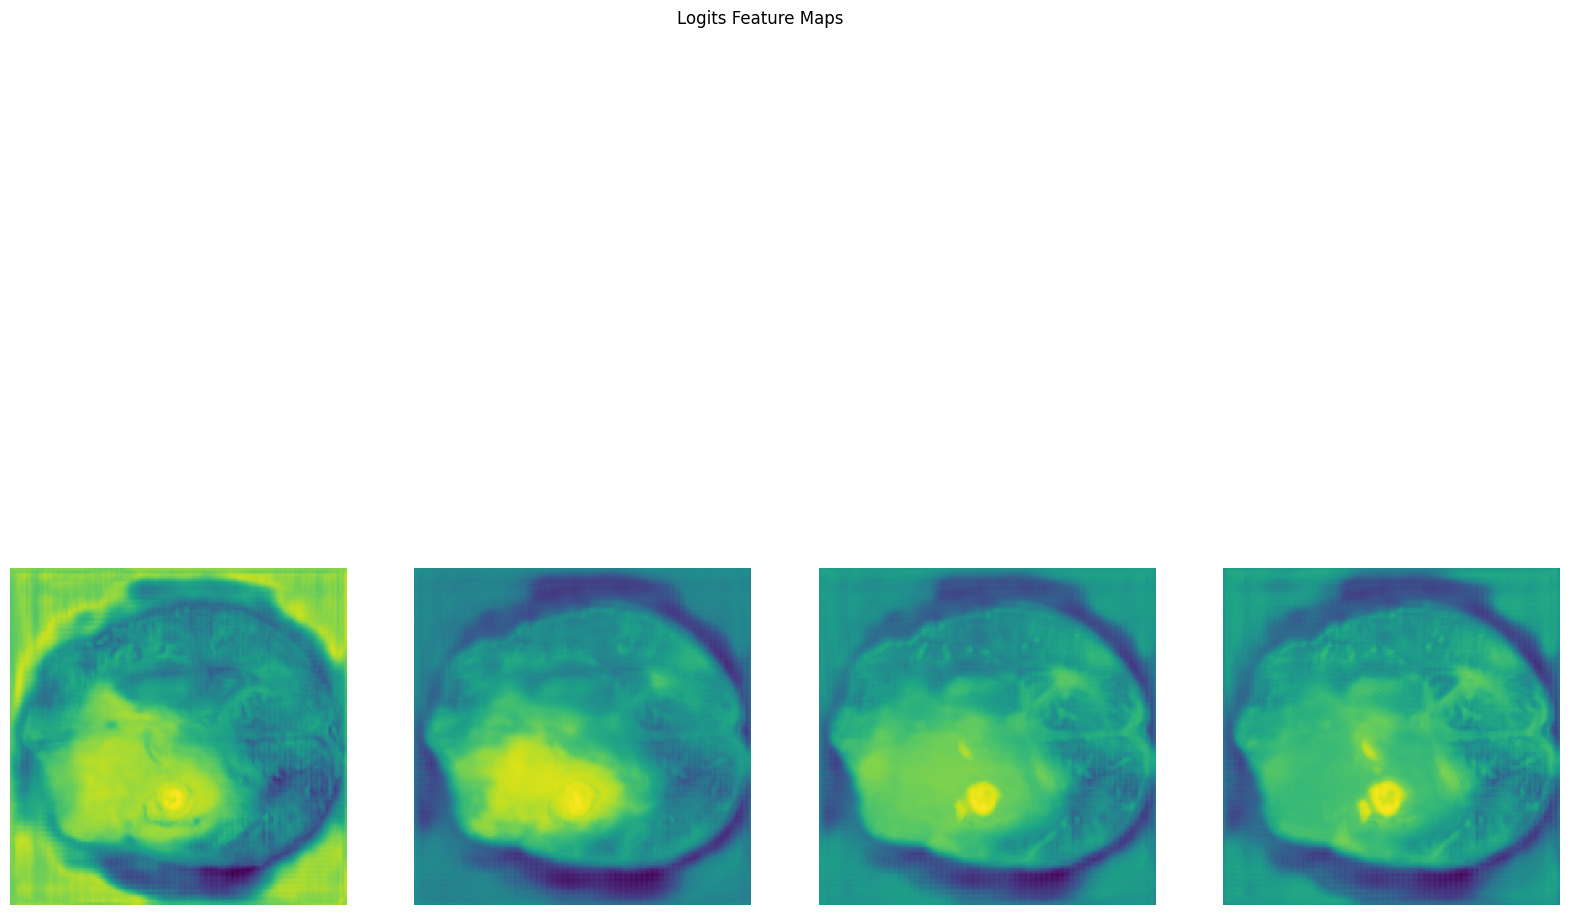

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

def visualize_feature_maps(feature_maps, title):
    # Extract a single slice (e.g., middle slice along the z-axis)
    slice_idx = feature_maps.shape[4] // 2
    feature_slice = feature_maps[0, :, :, :, slice_idx]  # Take first batch and all channels

    # Normalize the feature slice to [0, 1]
    feature_slice = (feature_slice - feature_slice.min()) / (feature_slice.max() - feature_slice.min())

    # Plot the feature maps
    num_channels = 4
    fig, axes = plt.subplots(1, num_channels, figsize=(20, 15))
    fig.suptitle(title)
    for i in range(num_channels):
        axes[i].imshow(feature_slice[i].cpu().detach().numpy(), cmap='viridis')
        axes[i].axis('off')
    plt.show()
    plt.tight_layout()

visualize_feature_maps(outputs['pred'], "Logits Feature Maps")

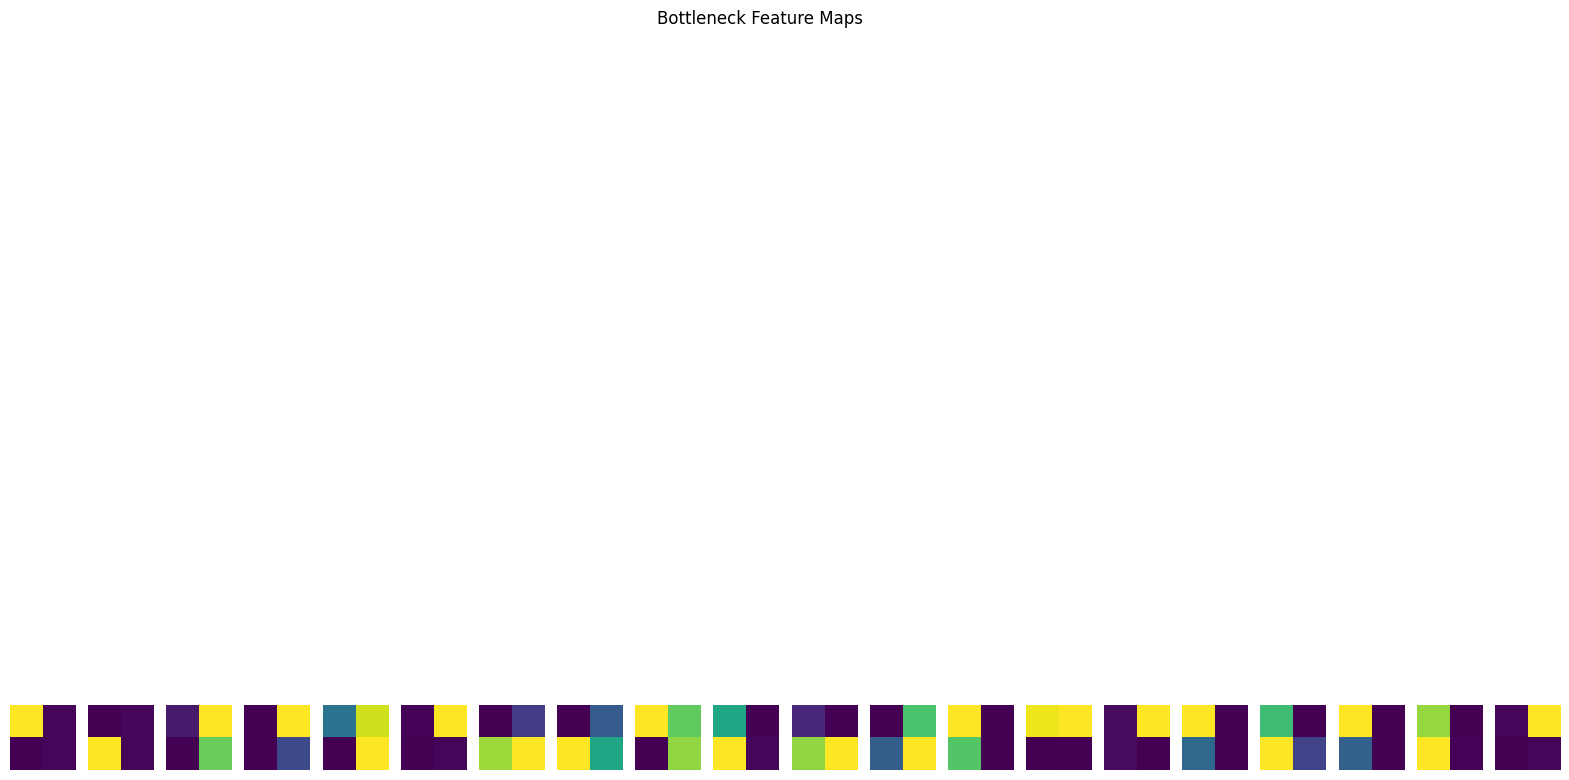

<Figure size 640x480 with 0 Axes>

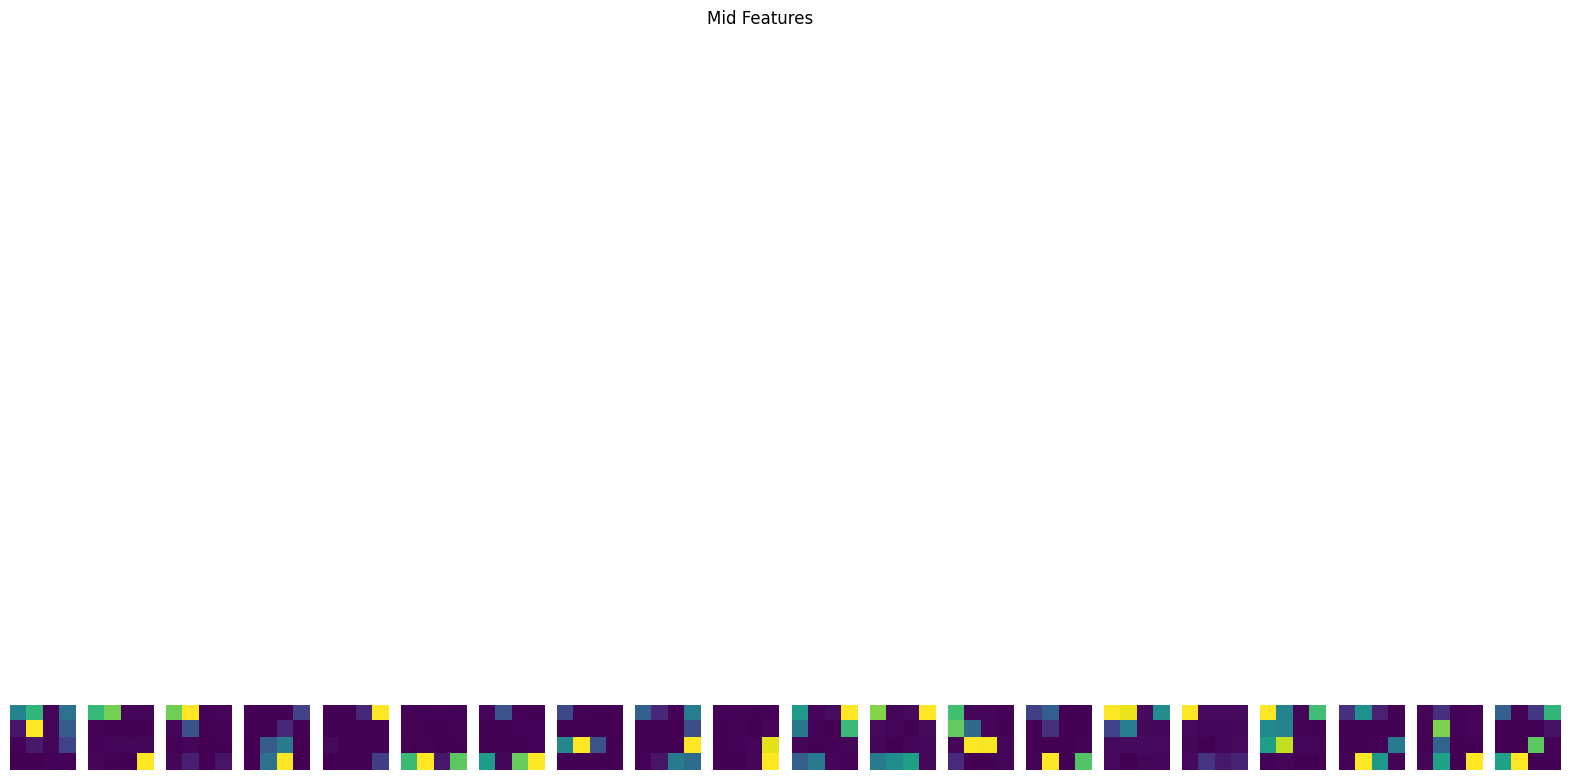

<Figure size 640x480 with 0 Axes>

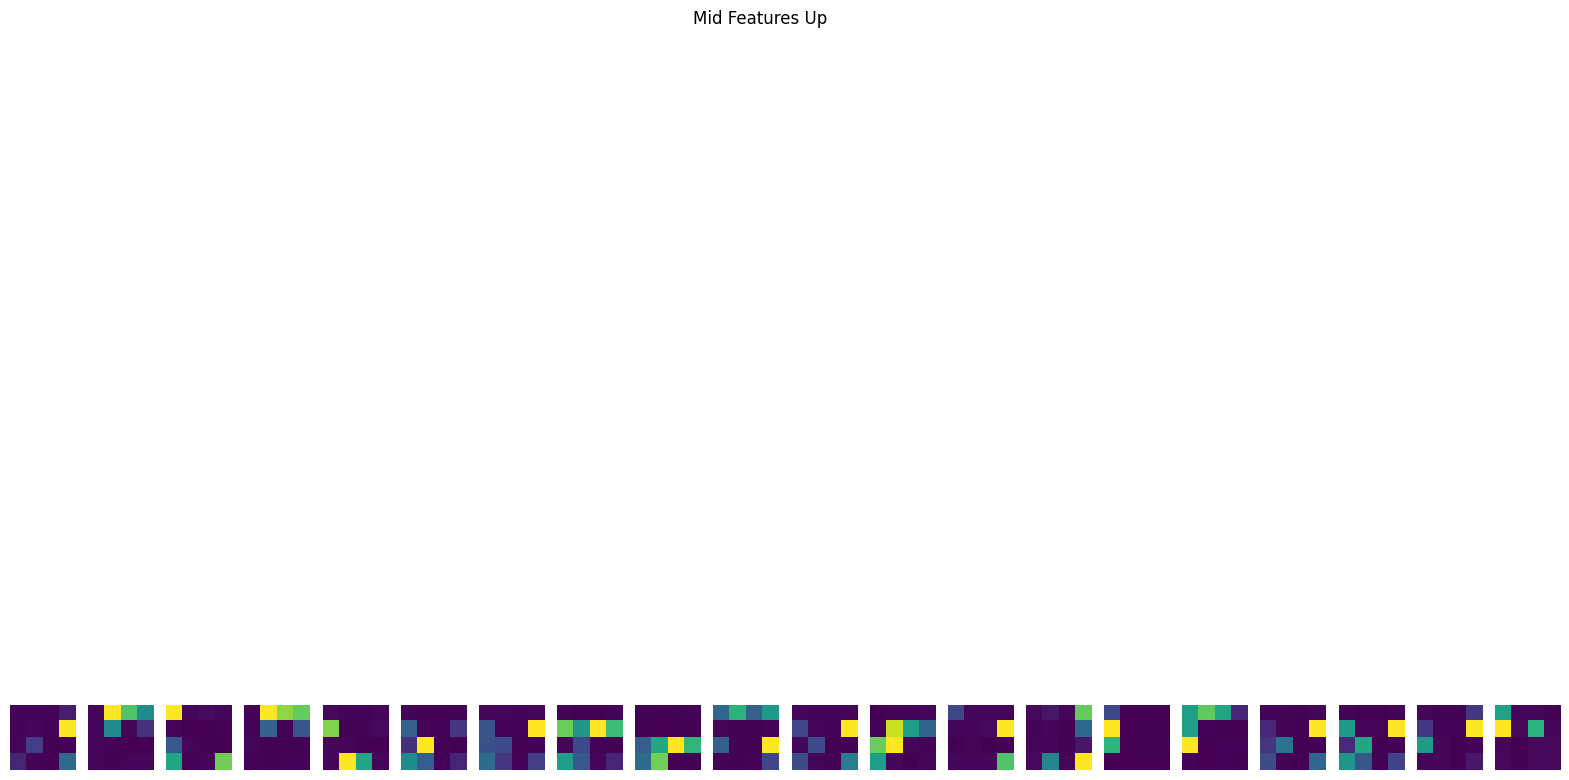

<Figure size 640x480 with 0 Axes>

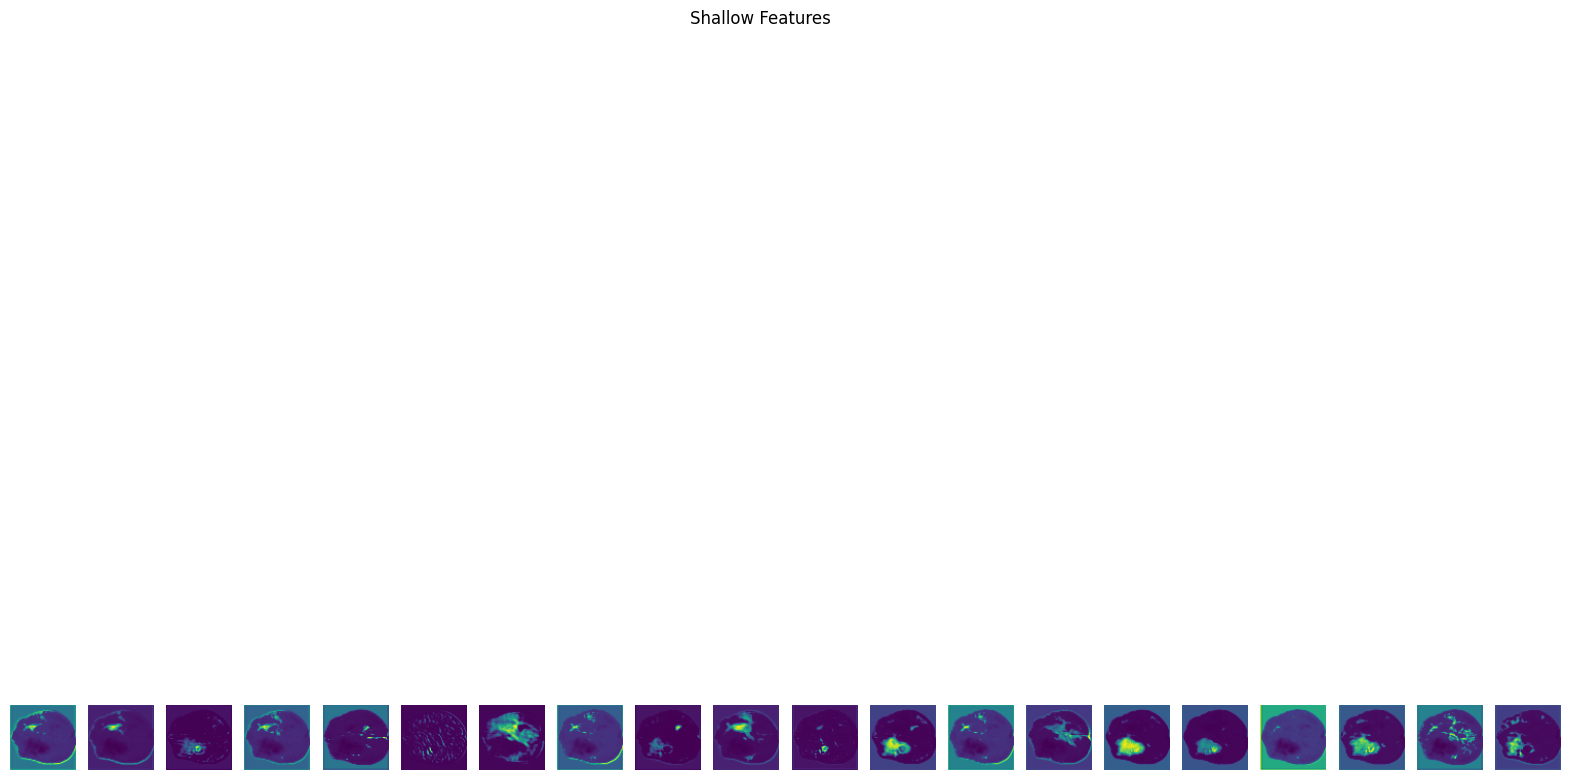

<Figure size 640x480 with 0 Axes>

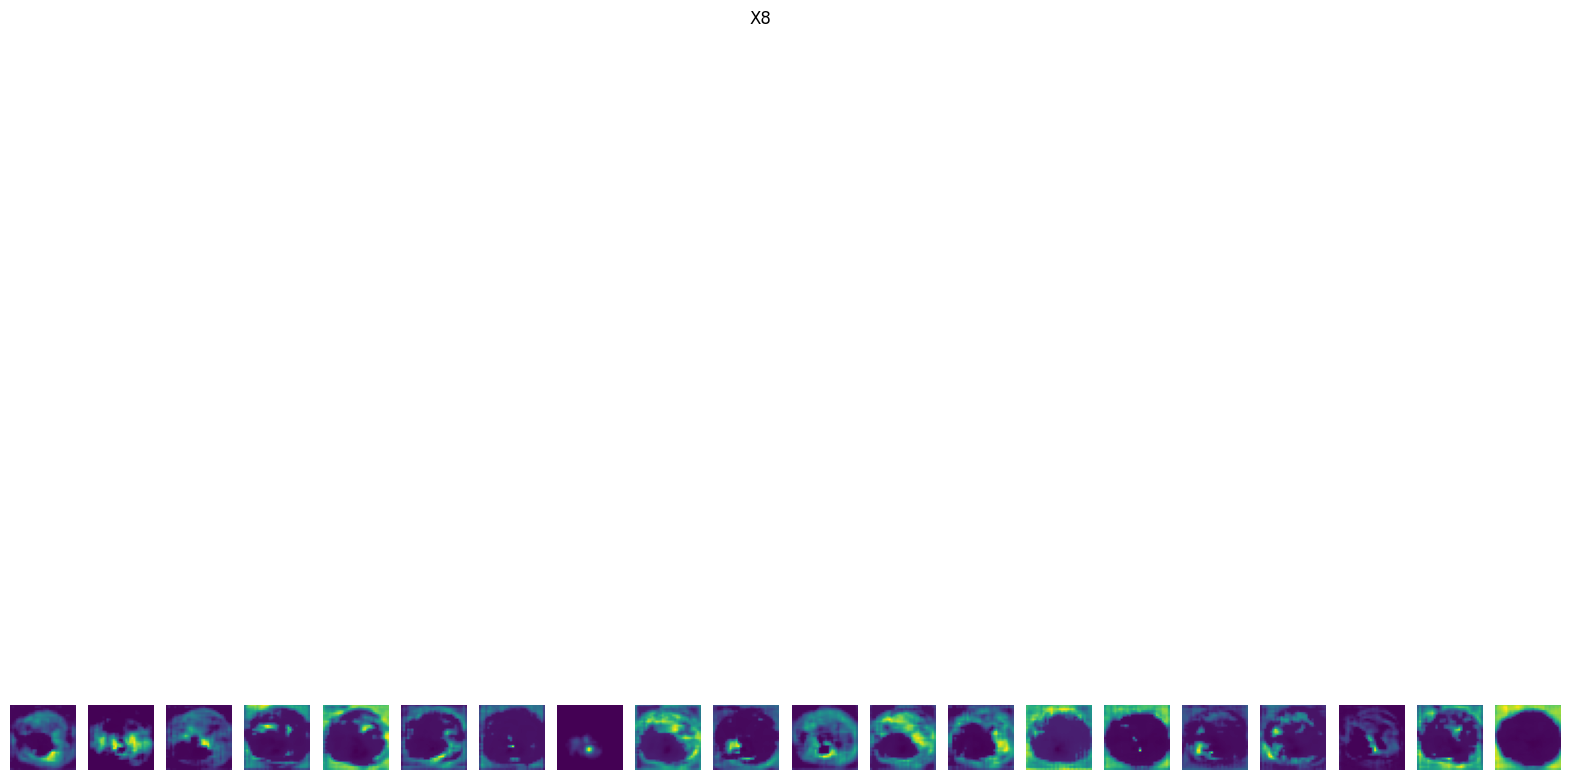

<Figure size 640x480 with 0 Axes>

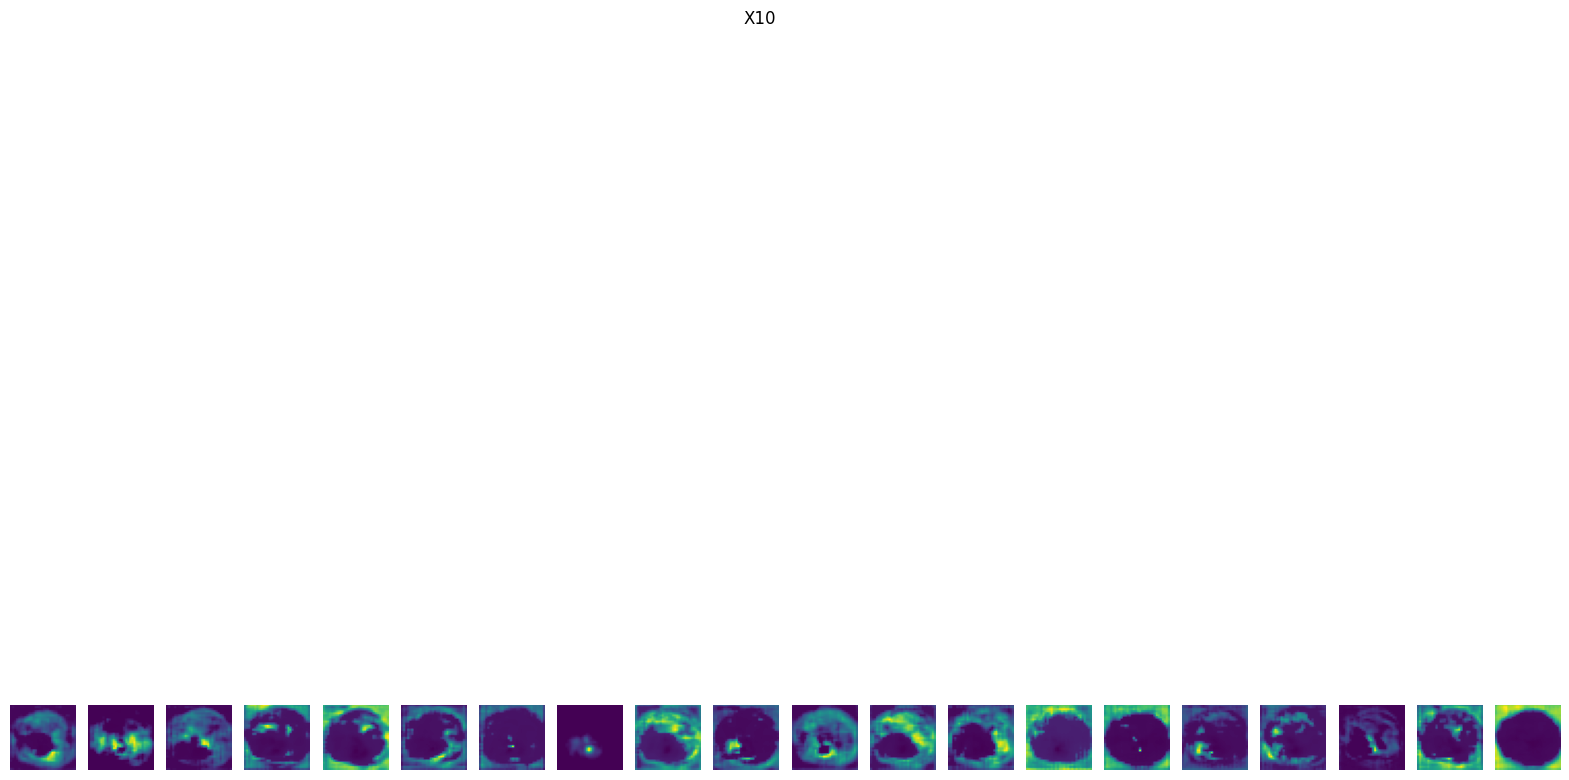

<Figure size 640x480 with 0 Axes>

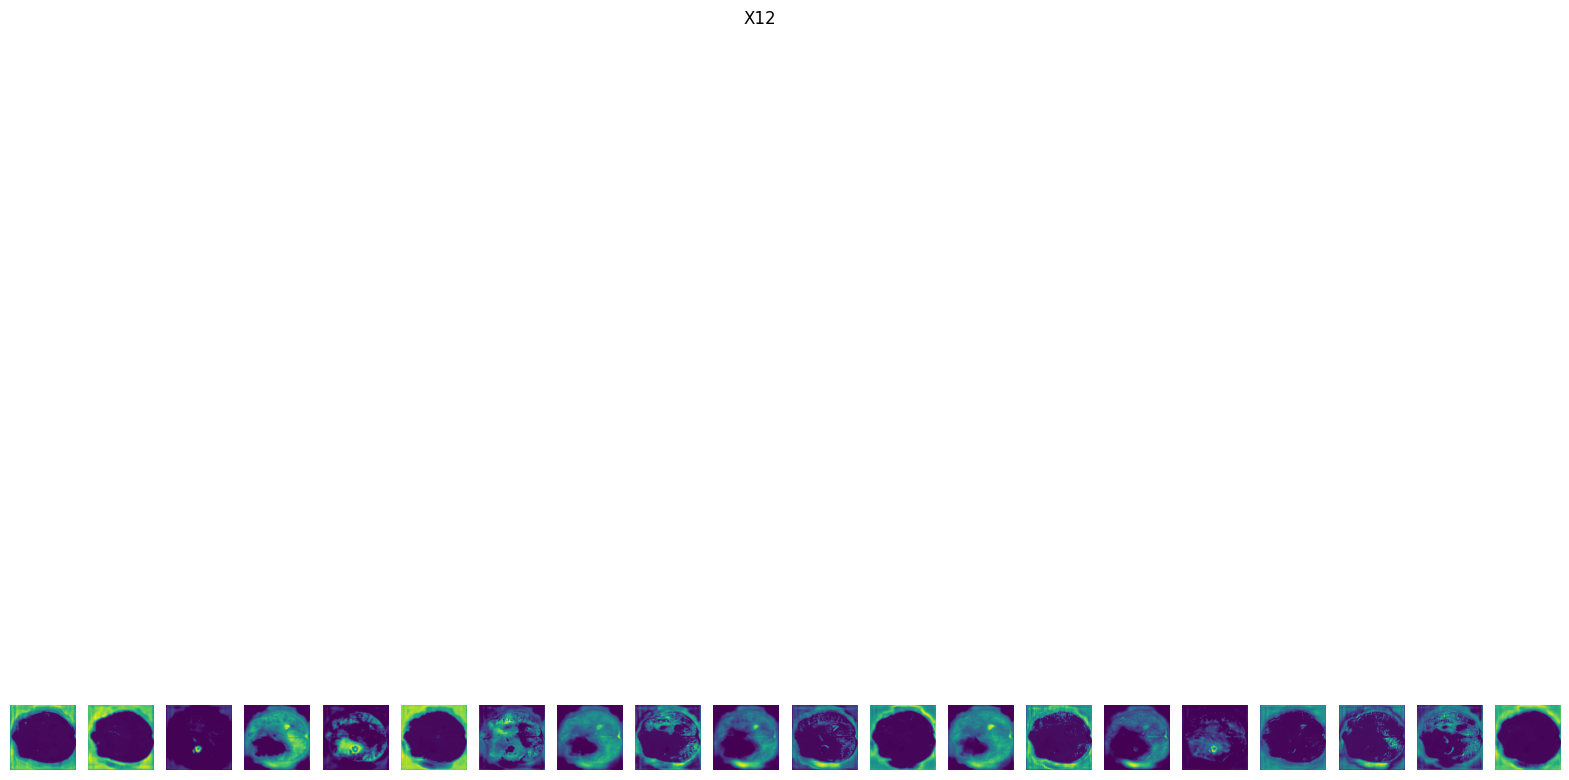

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

def visualize_feature_maps(feature_maps, title):
    slice_idx = feature_maps.shape[4] // 2
    feature_slice = feature_maps[0, :, :, :, slice_idx]

    # Normalize the feature slice to [0, 1]
    feature_slice = (feature_slice - feature_slice.min()) / (feature_slice.max() - feature_slice.min())
    
    num_channels = 20
    fig, axes = plt.subplots(1, num_channels, figsize=(20, 15))
    fig.suptitle(title)
    for i in range(num_channels):
        axes[i].imshow(feature_slice[20+i].cpu().detach().numpy(), cmap='viridis')
        axes[i].axis('off')
    plt.show()
    plt.tight_layout()

# Example usage
visualize_feature_maps(outputs['bottleneck'], "Bottleneck Feature Maps")
visualize_feature_maps(outputs['mid_features'], "Mid Features")
visualize_feature_maps(outputs['mid_features_up'], "Mid Features Up")
visualize_feature_maps(outputs['shallow_features'], "Shallow Features")
visualize_feature_maps(outputs['x8'], "X8")
visualize_feature_maps(outputs['x10'], "X10")
visualize_feature_maps(outputs['x12'], "X12")